In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

/tmp/ipykernel_106/3055796230.py:15: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  df_gmsc['GmSc_avg_5'] = df_gmsc[gmsc_columns].rolling(window=window_size, axis=1).mean().iloc[:, -1]  # 过去5场比赛的平均值
/tmp/ipykernel_106/3055796230.py:16: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  df_gmsc['GmSc_max_5'] = df_gmsc[gmsc_columns].rolling(window=window_size, axis=1).max().iloc[:, -1]  # 过去5场比赛的最大值
/tmp/ipykernel_106/3055796230.py:17: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  df_gmsc['GmSc_std_5'] = df_gmsc[gmsc_columns].rolling(window=window_size, axis=1).std().iloc[:, -1]  # 过去5场比赛的标准差


Mean Squared Error (MSE): 0.01367289629629248
R² Score: 0.2512813683074133


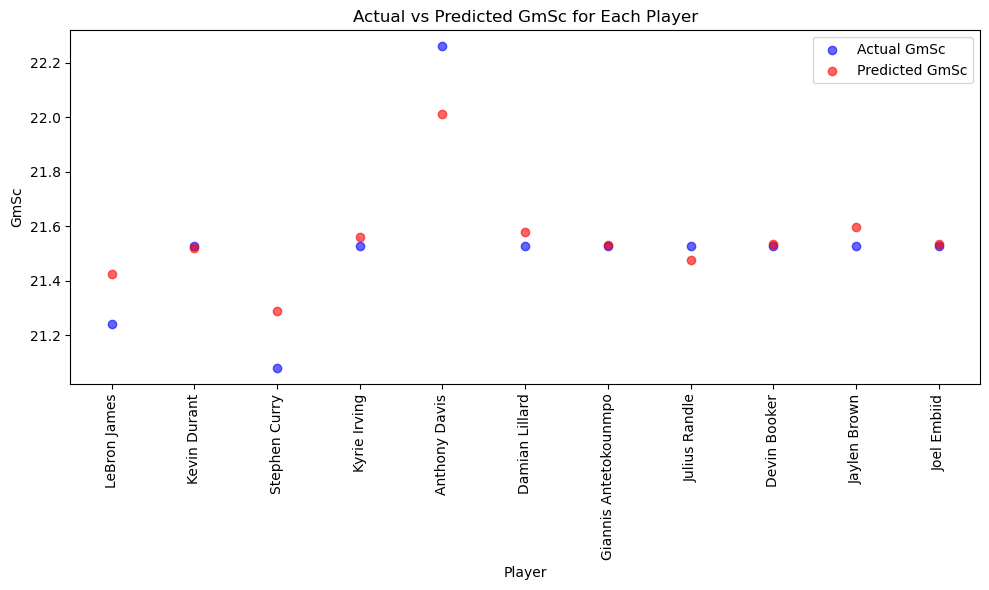

                   Player  GmSc_avg_5  Predicted_GmSc
0            LeBron James   21.240000       21.423600
1            Kevin Durant   21.526667       21.520600
2           Stephen Curry   21.080000       21.288933
3            Kyrie Irving   21.526667       21.559800
4           Anthony Davis   22.260000       22.013533
5          Damian Lillard   21.526667       21.577333
6   Giannis Antetokounmpo   21.526667       21.530800
7           Julius Randle   21.526667       21.477533
8            Devin Booker   21.526667       21.534000
9            Jaylen Brown   21.526667       21.595533
10            Joel Embiid   21.526667       21.534000


In [20]:
#1.根据球员的历史数据（如GmSc、身高、体重、大学、生日等个人信息）构建特征，并使用这些特征来预测球员的未来表现
# 读取数据
df_gmsc = pd.read_csv('22-23赛季球员GmSc1.csv')
df_personal = pd.read_csv('Players.csv')

# 重命名列
df_gmsc.rename(columns={'PlayerName': 'Player'}, inplace=True)

# 假设GmSc列从'GmSc1'到'GmSc81'，提取这些列
gmsc_columns = [col for col in df_gmsc.columns if 'GmSc' in col]

# 计算滑动窗口特征：过去5场比赛的GmSc平均值、最大值、标准差等
window_size = 5

# 计算每个球员的过去5场比赛的滑动窗口特征
df_gmsc['GmSc_avg_5'] = df_gmsc[gmsc_columns].rolling(window=window_size, axis=1).mean().iloc[:, -1]  # 过去5场比赛的平均值
df_gmsc['GmSc_max_5'] = df_gmsc[gmsc_columns].rolling(window=window_size, axis=1).max().iloc[:, -1]  # 过去5场比赛的最大值
df_gmsc['GmSc_std_5'] = df_gmsc[gmsc_columns].rolling(window=window_size, axis=1).std().iloc[:, -1]  # 过去5场比赛的标准差

# 内连接合并：只保留两个数据集都有的球员
df = pd.merge(df_personal, df_gmsc[['Player', 'GmSc_avg_5', 'GmSc_max_5', 'GmSc_std_5']], on='Player', how='inner')

# 填充缺失值：只对数值型列进行填充
num_cols = df.select_dtypes(include=['number']).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

# 对类别列进行标签编码
le = LabelEncoder()
df['collage'] = le.fit_transform(df['collage'].astype(str))
df['birth_city'] = le.fit_transform(df['birth_city'].astype(str))
df['birth_state'] = le.fit_transform(df['birth_state'].astype(str))

# 使用身高、体重、大学、生日等信息作为特征，GmSc平均值作为目标
X = df[['height', 'weight', 'collage', 'born', 'birth_city', 'birth_state', 'GmSc_avg_5', 'GmSc_max_5', 'GmSc_std_5']]  # 特征
y = df['GmSc_avg_5']  # 目标变量（GmSc的滑动窗口平均值）

# 标准化特征
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 训练随机森林回归模型
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 预测测试集
y_pred = model.predict(X_test)

# 计算均方误差和R²得分
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'R² Score: {r2}')

# 使用模型对所有球员进行预测
y_all_pred = model.predict(scaler.transform(df[['height', 'weight', 'collage', 'born', 'birth_city', 'birth_state', 'GmSc_avg_5', 'GmSc_max_5', 'GmSc_std_5']]))

# 将预测结果添加到 DataFrame 中
df['Predicted_GmSc'] = y_all_pred

# 绘制每个球员的实际表现与预测表现对比图
plt.figure(figsize=(10, 6))
plt.scatter(df['Player'], df['GmSc_avg_5'], color='blue', label='Actual GmSc', alpha=0.6)
plt.scatter(df['Player'], df['Predicted_GmSc'], color='red', label='Predicted GmSc', alpha=0.6)
plt.xticks(rotation=90)
plt.xlabel('Player')
plt.ylabel('GmSc')
plt.title('Actual vs Predicted GmSc for Each Player')
plt.legend()
plt.tight_layout()
plt.show()

# 输出包含预测结果的DataFrame
print(df[['Player', 'GmSc_avg_5', 'Predicted_GmSc']])






In [27]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import AgglomerativeClustering
from sklearn.impute import SimpleImputer
import scipy.cluster.hierarchy as sch

   Unnamed: 0           Player  height  weight  \
0           0  Curly Armstrong   180.0    77.0   
1           1     Cliff Barker   188.0    83.0   
2           2    Leo Barnhorst   193.0    86.0   
3           3       Ed Bartels   196.0    88.0   
4           4      Ralph Beard   178.0    79.0   

                           collage    born   birth_city birth_state  
0               Indiana University  1918.0          NaN         NaN  
1           University of Kentucky  1921.0     Yorktown     Indiana  
2         University of Notre Dame  1924.0          NaN         NaN  
3  North Carolina State University  1925.0          NaN         NaN  
4           University of Kentucky  1927.0  Hardinsburg    Kentucky  
Cluster
0    2256
2     843
1     823
Name: count, dtype: int64
Silhouette Score: 0.128


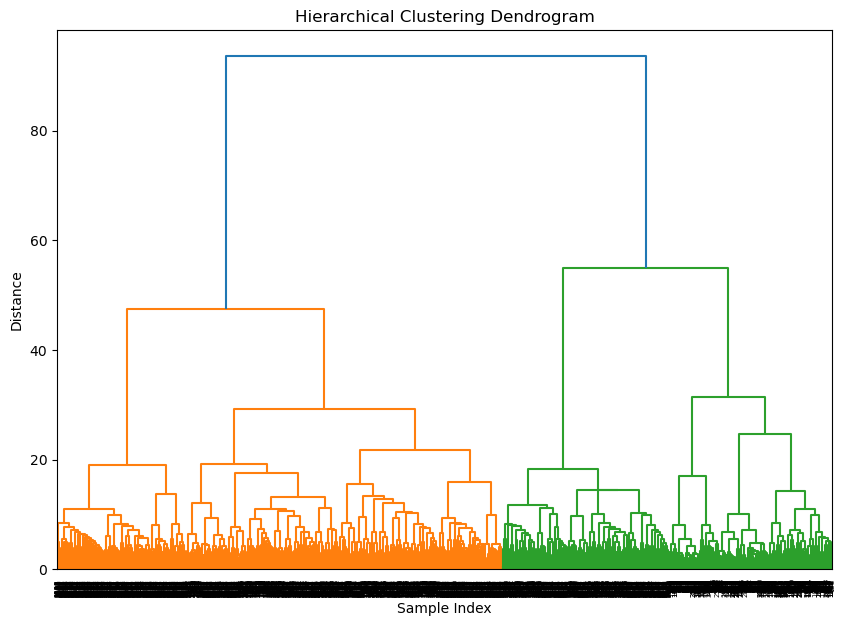

   Unnamed: 0           Player  height  weight  \
0           0  Curly Armstrong   180.0    77.0   
1           1     Cliff Barker   188.0    83.0   
2           2    Leo Barnhorst   193.0    86.0   
3           3       Ed Bartels   196.0    88.0   
4           4      Ralph Beard   178.0    79.0   

                           collage    born   birth_city birth_state  Cluster  
0               Indiana University  1918.0          NaN         NaN        1  
1           University of Kentucky  1921.0     Yorktown     Indiana        1  
2         University of Notre Dame  1924.0          NaN         NaN        1  
3  North Carolina State University  1925.0          NaN         NaN        1  
4           University of Kentucky  1927.0  Hardinsburg    Kentucky        1  


In [29]:
#2.
# 读取数据
df = pd.read_csv('Players.csv')

# 查看数据结构，确保文件已正确加载
print(df.head())

# 对数据进行预处理
numeric_features = ['height', 'weight','born']
imputer = SimpleImputer(strategy='mean')
df[numeric_features] = imputer.fit_transform(df[numeric_features])

# 数值型特征
numeric_features = ['height', 'weight','born']

# 类别型特征: 就读大学和生辰生地
categorical_features = ['collage', 'birth_city','birth_state']

# 创建一个预处理流程
# 对数值型数据进行标准化
# 对类别型数据进行独热编码
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(sparse_output=False), categorical_features)  # 设置 dense_output=False
    ])

# 构建聚类模型管道
# 使用层次聚类 (AgglomerativeClustering)
hierarchical = AgglomerativeClustering(n_clusters=3, linkage='ward')  # 这里设置了 3 个簇

# 创建完整的管道：先进行预处理，然后聚类
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('hierarchical', hierarchical)])

# 训练模型
pipeline.fit(df)

# 获取聚类标签
labels = pipeline.named_steps['hierarchical'].labels_

# 将聚类标签添加到原始数据中
df['Cluster'] = labels

# 打印每个簇的样本数量
print(df['Cluster'].value_counts())

# 评估聚类质量（轮廓系数）
sil_score = silhouette_score(preprocessor.transform(df), labels)
print(f"Silhouette Score: {sil_score:.3f}")

# 可视化树状图
plt.figure(figsize=(10, 7))
dendrogram = sch.dendrogram(sch.linkage(preprocessor.transform(df), method='ward'))
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()

# 查看聚类结果的样本（前几行）
print(df.head())

# 可选：保存聚类结果到新的CSV文件
df.to_csv('Player_with_clusters.csv', index=False)

/tmp/ipykernel_106/3470562484.py:13: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  df_gmsc['GmSc_avg_5'] = df_gmsc[gmsc_columns].rolling(window=window_size, axis=1).mean().iloc[:, -1]  # 过去5场比赛的平均值
/tmp/ipykernel_106/3470562484.py:14: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  df_gmsc['GmSc_max_5'] = df_gmsc[gmsc_columns].rolling(window=window_size, axis=1).max().iloc[:, -1]  # 过去5场比赛的最大值
/tmp/ipykernel_106/3470562484.py:15: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  df_gmsc['GmSc_std_5'] = df_gmsc[gmsc_columns].rolling(window=window_size, axis=1).std().iloc[:, -1]  # 过去5场比赛的标准差


Mean Squared Error (MSE): 0.01367289629629248
R² Score: 0.2512813683074133


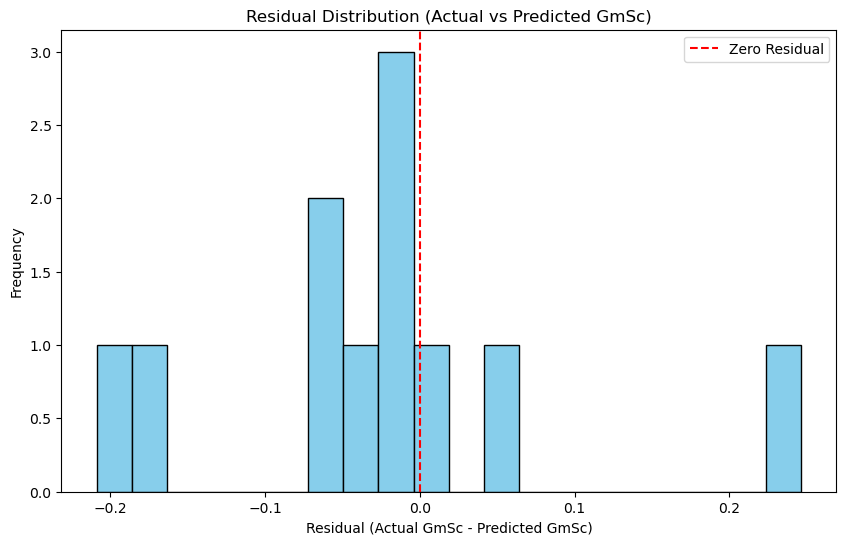

被低估的球员：
          Player  GmSc_avg_5  Predicted_GmSc  Residual
4  Anthony Davis       22.26       22.013533  0.246467
          Player  Residual  Underestimated
4  Anthony Davis  0.246467            True


In [33]:
#3.定义“被低估的球员”为实际 GmSc 表现高于预测值，即实际表现高于预测表现的一些球员，在数据上表现为gmsc残差较大根据此特征对这些球员进行识别：
# 读取数据
df_gmsc = pd.read_csv('22-23赛季球员GmSc1.csv')
df_personal = pd.read_csv('Players.csv')

# 重命名列
df_gmsc.rename(columns={'PlayerName': 'Player'}, inplace=True)

# 假设GmSc列从'GmSc1'到'GmSc81'，提取这些列
gmsc_columns = [col for col in df_gmsc.columns if 'GmSc' in col]

# 计算滑动窗口特征：过去5场比赛的GmSc平均值、最大值、标准差等
window_size = 5
df_gmsc['GmSc_avg_5'] = df_gmsc[gmsc_columns].rolling(window=window_size, axis=1).mean().iloc[:, -1]  # 过去5场比赛的平均值
df_gmsc['GmSc_max_5'] = df_gmsc[gmsc_columns].rolling(window=window_size, axis=1).max().iloc[:, -1]  # 过去5场比赛的最大值
df_gmsc['GmSc_std_5'] = df_gmsc[gmsc_columns].rolling(window=window_size, axis=1).std().iloc[:, -1]  # 过去5场比赛的标准差

# 内连接合并：只保留两个数据集都有的球员
df = pd.merge(df_personal, df_gmsc[['Player', 'GmSc_avg_5', 'GmSc_max_5', 'GmSc_std_5']], on='Player', how='inner')

# 填充缺失值：只对数值型列进行填充
num_cols = df.select_dtypes(include=['number']).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

# 对类别列进行标签编码
le = LabelEncoder()
df['collage'] = le.fit_transform(df['collage'].astype(str))
df['birth_city'] = le.fit_transform(df['birth_city'].astype(str))
df['birth_state'] = le.fit_transform(df['birth_state'].astype(str))

# 使用身高、体重、大学、生日等信息作为特征，GmSc平均值作为目标
X = df[['height', 'weight', 'collage', 'born', 'birth_city', 'birth_state', 'GmSc_avg_5', 'GmSc_max_5', 'GmSc_std_5']]  # 特征
y = df['GmSc_avg_5']  # 目标变量（GmSc的滑动窗口平均值）

# 标准化特征
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 训练随机森林回归模型
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 预测测试集
y_pred = model.predict(X_test)

# 计算均方误差和R²得分
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'R² Score: {r2}')

# 使用模型对所有球员进行预测
y_all_pred = model.predict(scaler.transform(df[['height', 'weight', 'collage', 'born', 'birth_city', 'birth_state', 'GmSc_avg_5', 'GmSc_max_5', 'GmSc_std_5']]))

# 将预测结果添加到 DataFrame 中
df['Predicted_GmSc'] = y_all_pred

# 计算残差（实际表现与预测表现的差异）
df['Residual'] = df['GmSc_avg_5'] - df['Predicted_GmSc']

# 绘制残差的直方图，查看残差的分布
plt.figure(figsize=(10, 6))
plt.hist(df['Residual'], bins=20, color='skyblue', edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', label='Zero Residual')
plt.title('Residual Distribution (Actual vs Predicted GmSc)')
plt.xlabel('Residual (Actual GmSc - Predicted GmSc)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# 计算残差的平均值和标准差
residual_mean = df['Residual'].mean()
residual_std = df['Residual'].std()

# 根据平均值 + 标准差来设定阈值
threshold = residual_mean + residual_std  # 可以调节阈值大小

# 识别被低估的球员：残差值大于阈值
df['Underestimated'] = df['Residual'] > threshold

# 打印被低估的球员
underestimated_players = df[df['Underestimated']]

print("被低估的球员：")
print(underestimated_players[['Player', 'GmSc_avg_5', 'Predicted_GmSc', 'Residual']])

# 可选：如果需要查看被低估球员的详细信息
print(underestimated_players[['Player', 'Residual', 'Underestimated']])